In [1]:
!pip install xgboost lightgbm shap torch torchvision torchaudio fastapi uvicorn pyngrok plotly dash scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 42.9 MB/s eta 0:00:00


Dataset loaded: 500 rows, 14 columns



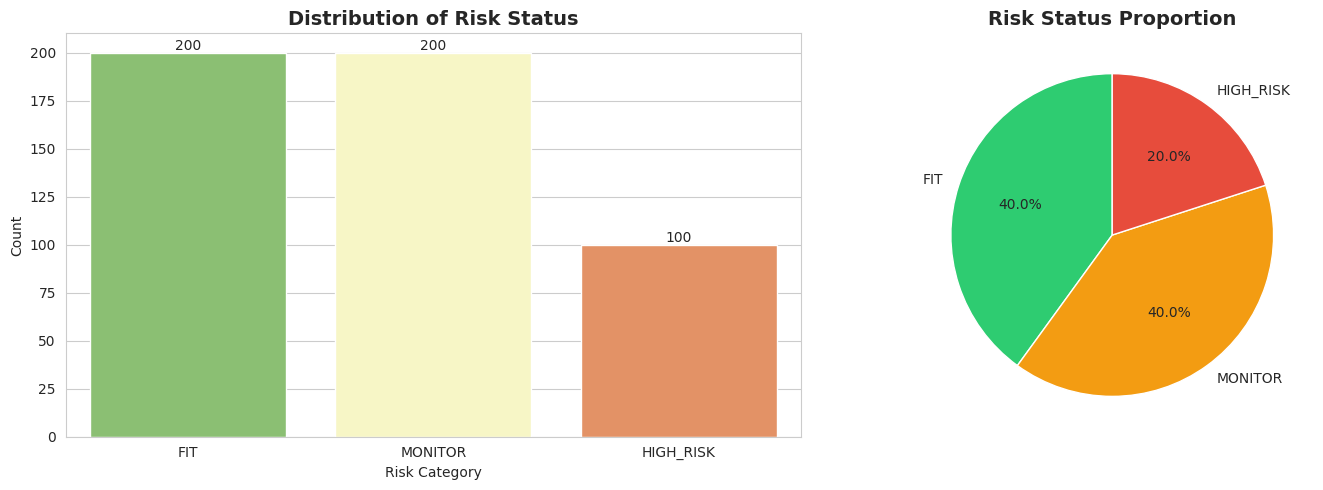

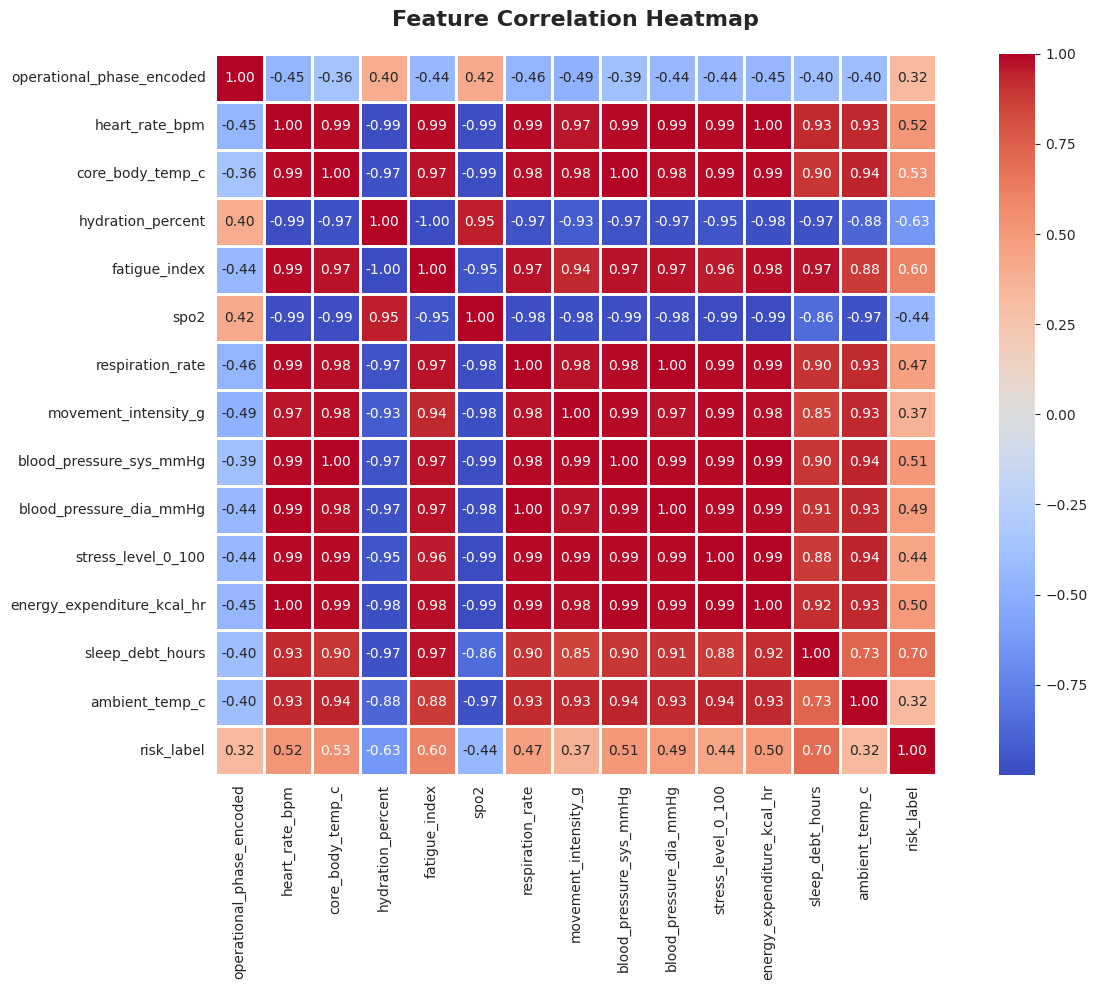

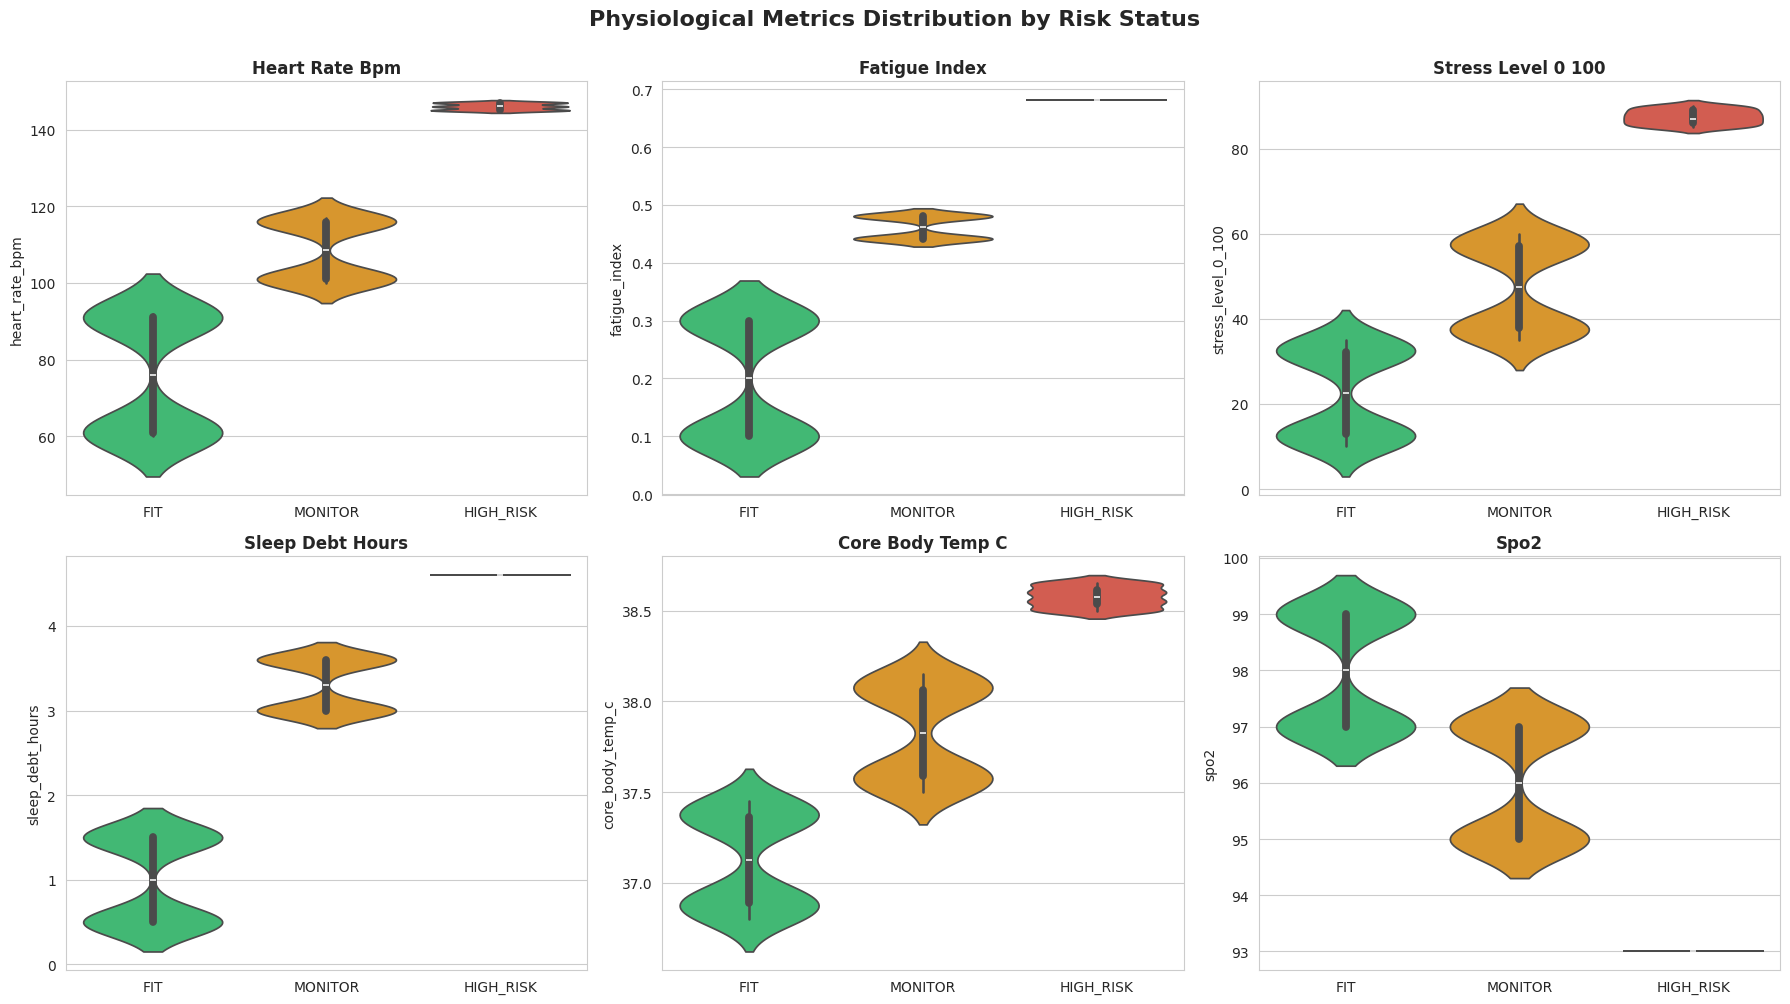

Training set: 400 samples
Test set: 100 samples

Training Random Forest Classifier...
Random Forest Accuracy: 1.0000

Training Gradient Boosting Classifier...
Gradient Boosting Accuracy: 1.0000

Training LSTM Model...
LSTM Training Complete

RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         FIT       1.00      1.00      1.00        43
   HIGH_RISK       1.00      1.00      1.00        19
     MONITOR       1.00      1.00      1.00        38

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


GRADIENT BOOSTING CLASSIFICATION REPORT
              precision    recall  f1-score   support

         FIT       1.00      1.00      1.00        43
   HIGH_RISK       1.00      1.00      1.00        19
     MONITOR       1.00      1.00      1.00        38

    accuracy                           1.00       100
   macro avg       1.00     

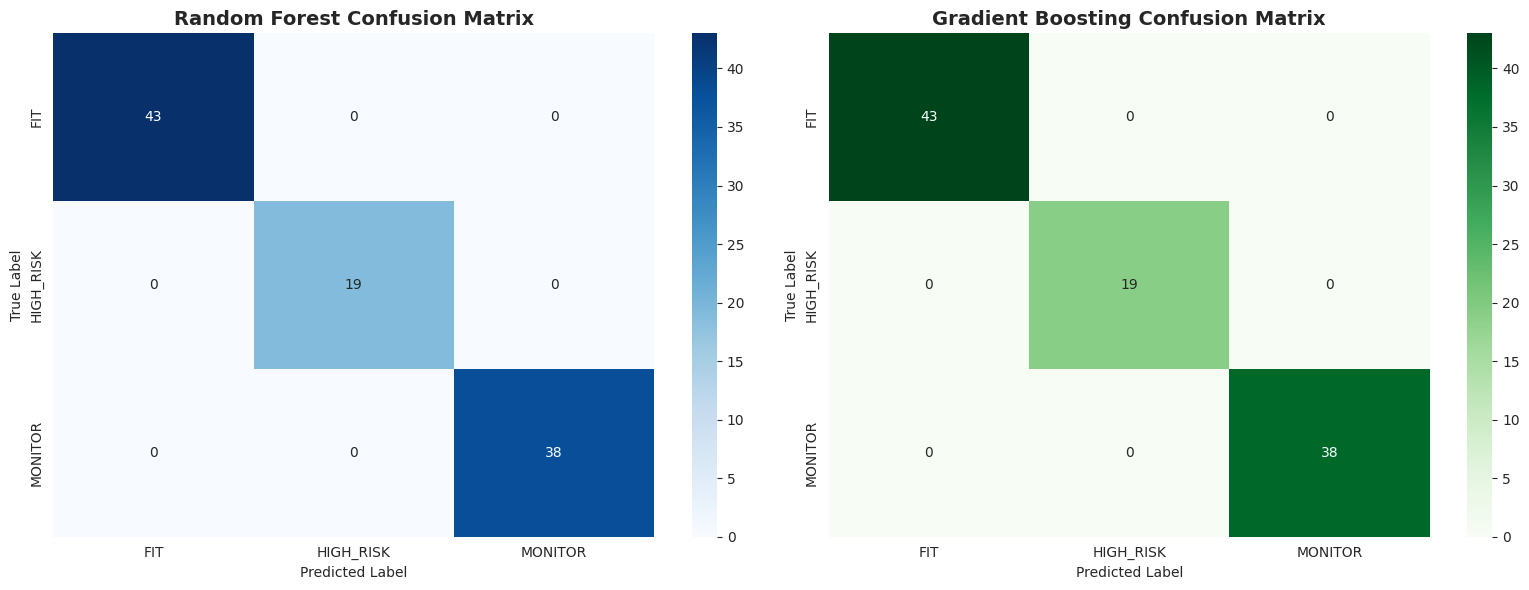

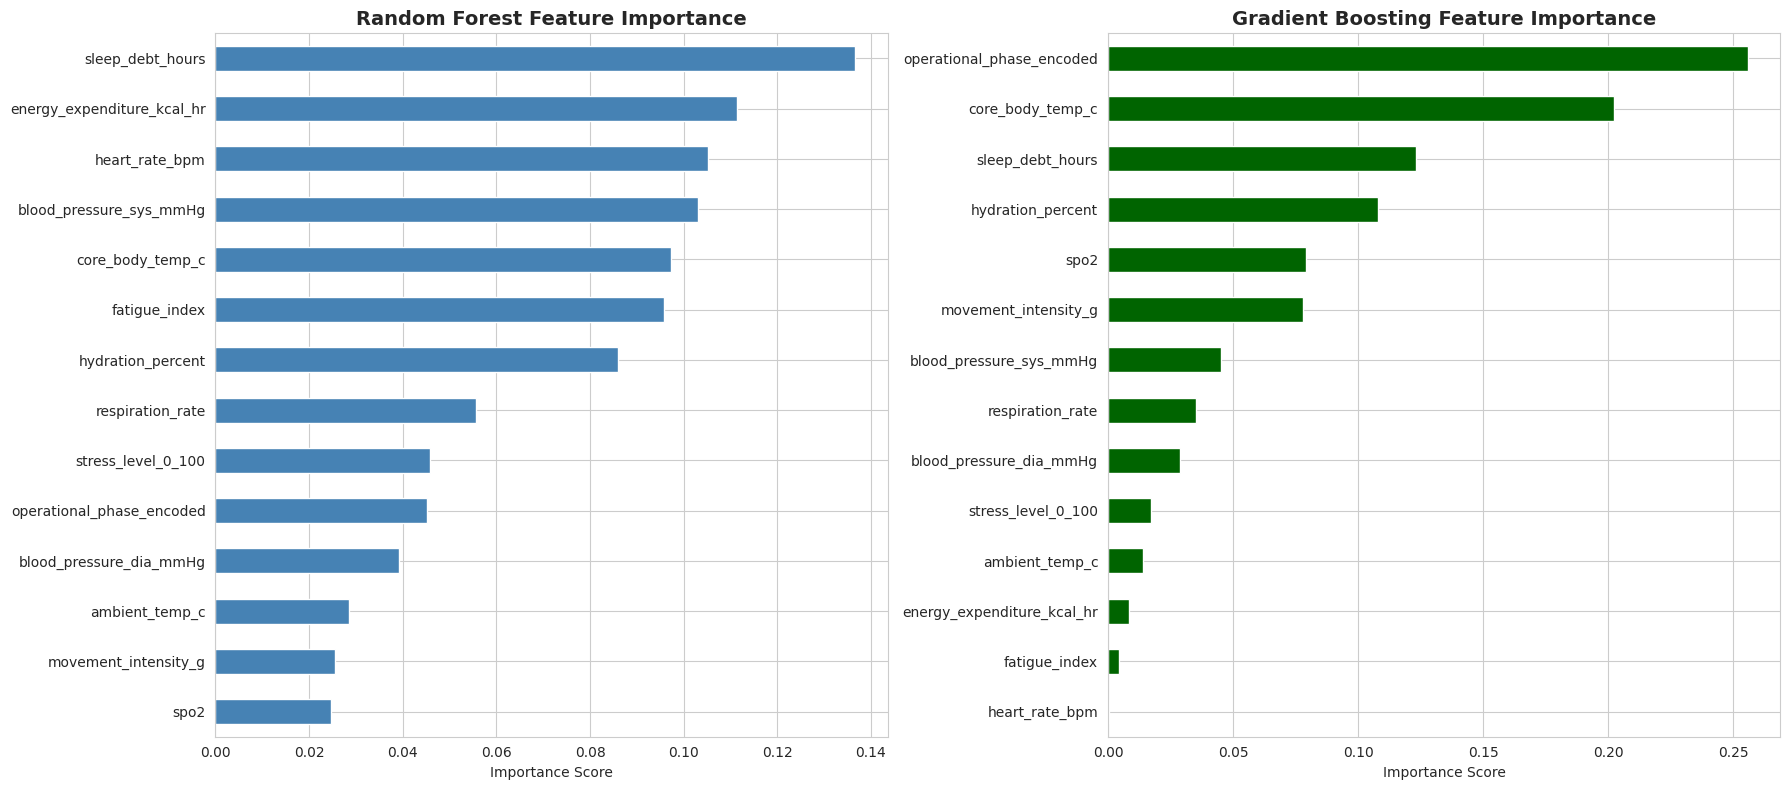

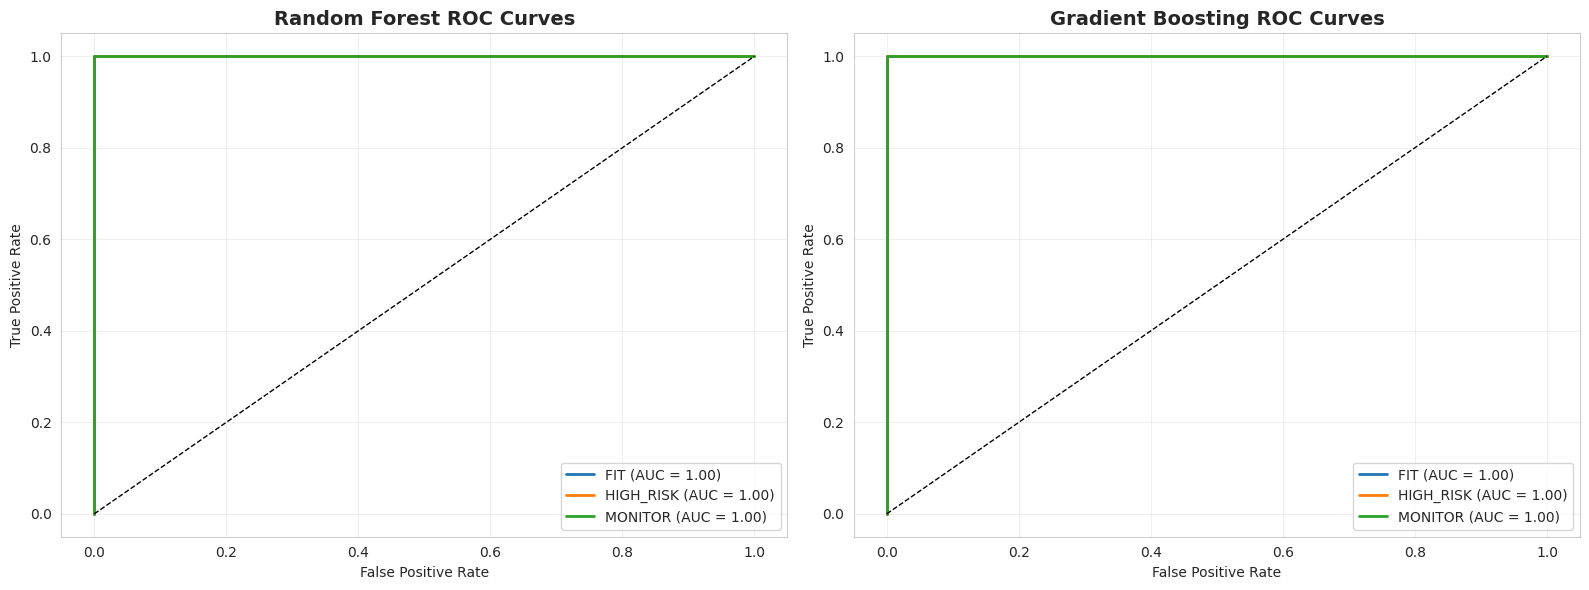

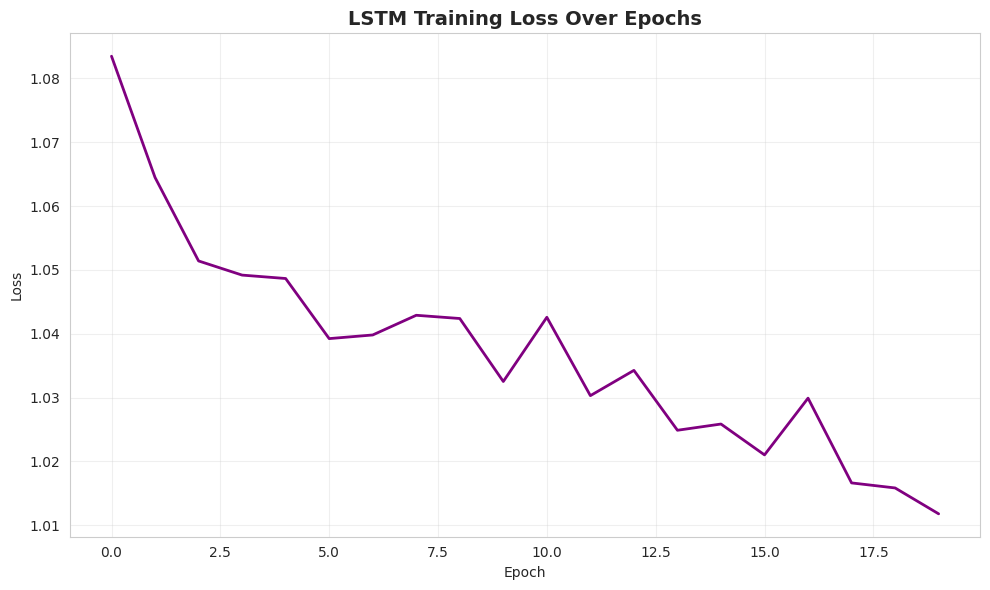

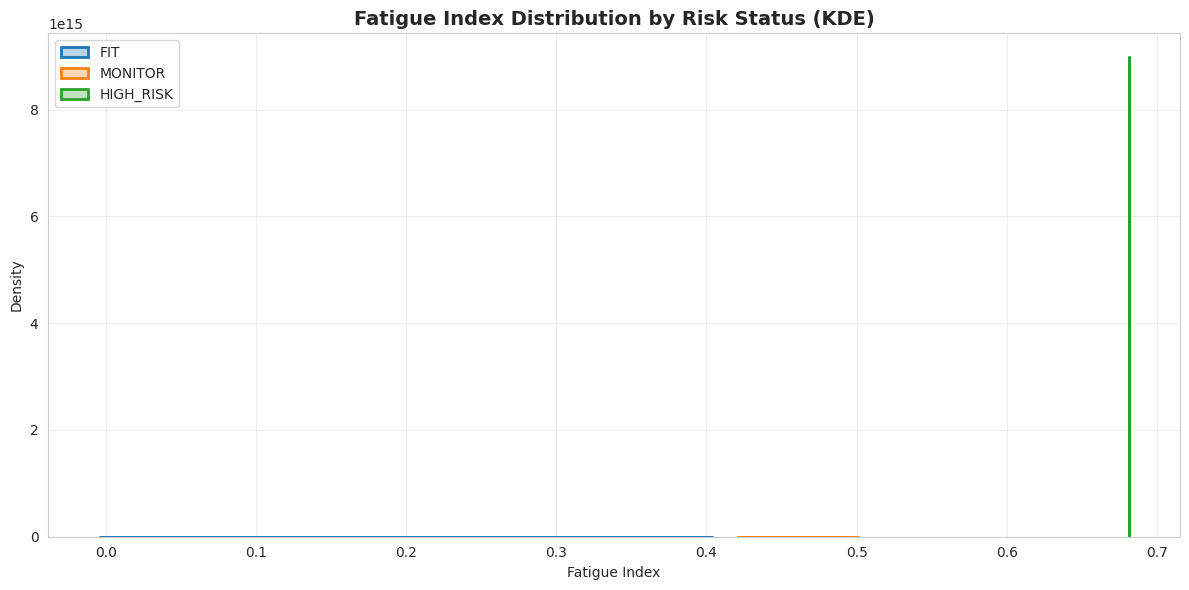


ANALYSIS COMPLETE
RF Accuracy: 1.0000 | GB Accuracy: 1.0000
Visualizations: 8 PNG + 4 HTML files saved


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.metrics import precision_recall_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ===============================================
# 1. LOAD DATASET
# ===============================================
df = pd.read_csv("/content/drive/MyDrive/soldierx/military_wearable_synthetic_500_rows.csv")
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")


# ===============================================
# 2. DATA PREPARATION & LABELING
# ===============================================
# Normalize fatigue (ensure 0-1 range)
if df['fatigue_index'].max() > 1:
    df['fatigue_index'] = df['fatigue_index'] / 100.0

# Encode Operational Phases
phase_le = LabelEncoder()
df['operational_phase_encoded'] = phase_le.fit_transform(df['operational_phase'].str.strip().str.lower())

# Logic-Based Labeling (Readiness & Risk)
def get_risk_label(row):
    score = 100 - (row['fatigue_index'] * 40) - (row['stress_level_0_100'] * 0.3)
    score -= row['sleep_debt_hours'] * 1.5
    score -= max(0, row['core_body_temp_c'] - 37.5) * 10
    if score >= 70: return "FIT"
    elif score >= 40: return "MONITOR"
    else: return "HIGH_RISK"

df['risk_status'] = df.apply(get_risk_label, axis=1)
risk_le = LabelEncoder()
df['risk_label'] = risk_le.fit_transform(df['risk_status'])

# ===============================================
# 3. EXPLORATORY DATA ANALYSIS WITH VISUALIZATIONS
# ===============================================

# 3.1 Distribution of Risk Status
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=df, x='risk_status', palette='RdYlGn_r', ax=axes[0])
axes[0].set_title('Distribution of Risk Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Category')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
risk_counts = df['risk_status'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1].pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Risk Status Proportion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 Interactive Plotly: Risk by Operational Phase
fig_phase = px.histogram(df, x='operational_phase', color='risk_status',
                         title='Risk Distribution Across Operational Phases',
                         barmode='group',
                         color_discrete_map={'FIT': '#2ecc71', 'MONITOR': '#f39c12', 'HIGH_RISK': '#e74c3c'})
fig_phase.update_layout(xaxis_title='Operational Phase', yaxis_title='Count')
fig_phase.write_html('risk_by_phase.html')
fig_phase.show()

# 3.3 Correlation Heatmap
features = [
    'operational_phase_encoded', 'heart_rate_bpm', 'core_body_temp_c',
    'hydration_percent', 'fatigue_index', 'spo2', 'respiration_rate',
    'movement_intensity_g', 'blood_pressure_sys_mmHg',
    'blood_pressure_dia_mmHg', 'stress_level_0_100',
    'energy_expenditure_kcal_hr', 'sleep_debt_hours', 'ambient_temp_c'
]

plt.figure(figsize=(14, 10))
correlation_matrix = df[features + ['risk_label']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.4 Violin plots for key metrics by risk status
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
key_metrics = ['heart_rate_bpm', 'fatigue_index', 'stress_level_0_100',
               'sleep_debt_hours', 'core_body_temp_c', 'spo2']
colors = ['FIT', 'MONITOR', 'HIGH_RISK']
palette = {'FIT': '#2ecc71', 'MONITOR': '#f39c12', 'HIGH_RISK': '#e74c3c'}

for idx, metric in enumerate(key_metrics):
    row, col = idx // 3, idx % 3
    sns.violinplot(data=df, x='risk_status', y=metric, ax=axes[row, col],
                   palette=palette, order=['FIT', 'MONITOR', 'HIGH_RISK'])
    axes[row, col].set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
    axes[row, col].set_xlabel('')

plt.suptitle('Physiological Metrics Distribution by Risk Status',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('metrics_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.5 Interactive 3D Scatter Plot
fig_3d = px.scatter_3d(df, x='heart_rate_bpm', y='stress_level_0_100',
                        z='fatigue_index', color='risk_status',
                        title='3D Risk Assessment Space',
                        color_discrete_map={'FIT': '#2ecc71', 'MONITOR': '#f39c12', 'HIGH_RISK': '#e74c3c'},
                        opacity=0.7, size_max=10)
fig_3d.update_layout(scene=dict(xaxis_title='Heart Rate (BPM)',
                                yaxis_title='Stress Level',
                                zaxis_title='Fatigue Index'))
fig_3d.write_html('3d_risk_space.html')
fig_3d.show()

# ===============================================
# 4. FEATURE SELECTION & SCALING
# ===============================================
X = df[features]
y = df['risk_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

# ===============================================
# 5. MODEL 1: RANDOM FOREST (Robust Baseline)
# ===============================================
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}\n")

# ===============================================
# 6. MODEL 2: GRADIENT BOOSTING (High Performance)
# ===============================================
print("Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}\n")

# ===============================================
# 7. MODEL 3: PYTORCH LSTM (For Sequential Monitoring)
# ===============================================
class SoldierDataset(Dataset):
    def __init__(self, X, y, seq_len=5):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Training LSTM
print("Training LSTM Model...")
lstm = LSTMModel(len(features), 64, len(risk_le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

train_dataset = SoldierDataset(X_train_scaled, y_train, seq_len=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

lstm_losses = []
for epoch in range(20):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lstm_losses.append(epoch_loss / len(train_loader))

print(f"LSTM Training Complete\n")

# ===============================================
# 8. COMPREHENSIVE EVALUATION & VISUALIZATION
# ===============================================

# 8.1 Classification Reports
print("=" * 60)
print("RANDOM FOREST CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, rf_pred, target_names=risk_le.classes_))

print("\n" + "=" * 60)
print("GRADIENT BOOSTING CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, gb_pred, target_names=risk_le.classes_))

# 8.2 Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=risk_le.classes_, yticklabels=risk_le.classes_)
axes[0].set_title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_gb = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=risk_le.classes_, yticklabels=risk_le.classes_)
axes[1].set_title('Gradient Boosting Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.3 Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

rf_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)
rf_importance.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance Score')

gb_importance = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=True)
gb_importance.plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Gradient Boosting Feature Importance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.4 Interactive Feature Importance (Plotly)
importance_df = pd.DataFrame({
    'Feature': features,
    'Random Forest': rf_model.feature_importances_,
    'Gradient Boosting': gb_model.feature_importances_
}).sort_values('Random Forest', ascending=True)

fig_importance = go.Figure()
fig_importance.add_trace(go.Bar(
    y=importance_df['Feature'],
    x=importance_df['Random Forest'],
    name='Random Forest',
    orientation='h',
    marker=dict(color='steelblue')
))
fig_importance.add_trace(go.Bar(
    y=importance_df['Feature'],
    x=importance_df['Gradient Boosting'],
    name='Gradient Boosting',
    orientation='h',
    marker=dict(color='darkgreen')
))
fig_importance.update_layout(
    title='Feature Importance Comparison',
    xaxis_title='Importance Score',
    yaxis_title='Features',
    barmode='group',
    height=600
)
fig_importance.write_html('feature_importance_interactive.html')
fig_importance.show()

# 8.5 ROC Curves (Multi-class)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, class_name in enumerate(risk_le.classes_):
    y_test_binary = (y_test == i).astype(int)

    # Random Forest ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test_binary, rf_pred_proba[:, i])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    axes[0].plot(fpr_rf, tpr_rf, label=f'{class_name} (AUC = {roc_auc_rf:.2f})', linewidth=2)

    # Gradient Boosting ROC
    fpr_gb, tpr_gb, _ = roc_curve(y_test_binary, gb_pred_proba[:, i])
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    axes[1].plot(fpr_gb, tpr_gb, label=f'{class_name} (AUC = {roc_auc_gb:.2f})', linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_title('Random Forest ROC Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title('Gradient Boosting ROC Curves', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.6 Model Comparison Dashboard (Plotly)
models = ['Random Forest', 'Gradient Boosting']
accuracies = [rf_accuracy, gb_accuracy]

fig_compare = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Model Accuracy Comparison', 'F1 Scores by Class'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}]]
)

# Accuracy comparison
fig_compare.add_trace(
    go.Bar(x=models, y=accuracies, marker_color=['steelblue', 'darkgreen'],
           text=[f'{acc:.3f}' for acc in accuracies], textposition='auto'),
    row=1, col=1
)

# F1 scores
rf_f1 = f1_score(y_test, rf_pred, average=None)
gb_f1 = f1_score(y_test, gb_pred, average=None)

fig_compare.add_trace(
    go.Bar(name='Random Forest', x=risk_le.classes_, y=rf_f1, marker_color='steelblue'),
    row=1, col=2
)
fig_compare.add_trace(
    go.Bar(name='Gradient Boosting', x=risk_le.classes_, y=gb_f1, marker_color='darkgreen'),
    row=1, col=2
)

fig_compare.update_xaxes(title_text="Model", row=1, col=1)
fig_compare.update_yaxes(title_text="Accuracy", row=1, col=1)
fig_compare.update_xaxes(title_text="Risk Class", row=1, col=2)
fig_compare.update_yaxes(title_text="F1 Score", row=1, col=2)
fig_compare.update_layout(height=500, showlegend=True, title_text="Model Performance Dashboard")
fig_compare.write_html('model_comparison_dashboard.html')
fig_compare.show()

# 8.7 LSTM Training Loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_losses, linewidth=2, color='purple')
plt.title('LSTM Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.8 Risk Score Distribution with KDE
plt.figure(figsize=(12, 6))
for risk_status in ['FIT', 'MONITOR', 'HIGH_RISK']:
    subset = df[df['risk_status'] == risk_status]['fatigue_index']
    sns.kdeplot(subset, label=risk_status, linewidth=2, fill=True, alpha=0.3)

plt.title('Fatigue Index Distribution by Risk Status (KDE)', fontsize=14, fontweight='bold')
plt.xlabel('Fatigue Index')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fatigue_kde_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ===============================================
# 9. SUMMARY STATISTICS
# ===============================================
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"RF Accuracy: {rf_accuracy:.4f} | GB Accuracy: {gb_accuracy:.4f}")
print(f"Visualizations: 8 PNG + 4 HTML files saved")
print("=" * 60)